# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import imresize, imread
from tqdm import tqdm_notebook, tnrange
import cv2
from glob import glob
import pickle
import peakutils
from scipy import signal
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

# Camera Calibration

In [2]:
ROWS = 6
COLS = 9
CAL_IMAGE_SIZE = (720, 1280, 3)
CALC_CAL_POINTS = False
CAL_IMAGE_PATH = 'camera_cal/calibration*.jpg'
CALIBRATION_PATH = 'camera_cal/calibration.p'

def calculate_camera_calibration(path_pattern, rows, cols, image_size):
    objp = np.zeros((rows*cols,3), np.float32)
    objp[:,:2] = np.mgrid[0:cols, 0:rows].T.reshape(-1,2)

    objpoints = []
    imgpoints = []

    images = glob(path_pattern)
    cal_images = np.zeros((len(images), *CAL_IMAGE_SIZE), dtype=np.uint8)

    successfull_cnt = 0
    for idx, fname in enumerate(tqdm_notebook(images, desc='Processing image')):
        img = imread(fname)
        if img.shape[0] != CAL_IMAGE_SIZE[0] or img.shape[1] != CAL_IMAGE_SIZE[1]:
            img = imresize(img, CAL_IMAGE_SIZE)

        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (cols, rows), None) 

        if ret == True:
            successfull_cnt +=1

            objpoints.append(objp)
            imgpoints.append(corners)

            img = cv2.drawChessboardCorners(img, (cols, rows), corners, ret)
            cal_images[idx] = img

    print("%s/%s camera calibration images processed." % (successfull_cnt,len(images)))
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, CAL_IMAGE_SIZE[:-1], None, None)
    
    calibration = {'objpoints': objpoints,
                   'imgpoints': imgpoints,
                   'cal_images': cal_images,
                   'mtx': mtx,
                   'dist': dist,
                   'rvecs': rvecs,
                   'tvecs': tvecs}
    
    return calibration

def get_camera_calibration():
    if CALC_CAL_POINTS:
        calibration = calculate_camera_calibration(CAL_IMAGE_PATH, ROWS, COLS, CAL_IMAGE_SIZE)
        with open(CALIBRATION_PATH, 'wb') as f:
            pickle.dump(calibration, file=f)
    else:
        with open(CALIBRATION_PATH, "rb" ) as f:
            calibration = pickle.load(f)
            
    return calibration;

# Helper Functions

In [65]:
def cal_undistort(img):
    calibration = get_camera_calibration()
    objpoints = calibration['objpoints']
    imgpoints = calibration['imgpoints']
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst


def abs_sobel_thresh(img_ch, orient='x', sobel_kernel=3, thresh=(0, 255)):  
    if orient == 'x':
        axis = (1, 0)
    elif orient == 'y':
        axis = (0, 1)
    else:
        raise ValueError('orient has to be "x" or "y" not "%s"' % orient)
    
    sobel = cv2.Sobel(img_ch, cv2.CV_64F, *axis)
    abss = np.absolute(sobel)
    
    scale_factor = np.max(abss)/255
    abss = (abss/scale_factor).astype(np.uint8)
    
    binary_output = np.zeros_like(abss)
    binary_output[(abss > thresh[0]) & (abss < thresh[1])] = 1
    
    return binary_output


def mag_thresh(img_ch, sobel_kernel=3, thresh=(0, 255)):    
    sobelx = cv2.Sobel(img_ch, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img_ch, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    abs_grad_mag = np.sqrt(sobelx**2+sobely**2)

    scale_factor = np.max(abs_grad_mag)/255
    abs_grad_mag = (abs_grad_mag/scale_factor).astype(np.uint8)
    
    mag_binary = np.zeros_like(abs_grad_mag)
    mag_binary[(abs_grad_mag > thresh[0]) & (abs_grad_mag < thresh[1])] = 1

    return mag_binary


def dir_threshold(img_ch, sobel_kernel=3, thresh=(0, np.pi/2)):    
    sobelx = cv2.Sobel(img_ch, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img_ch, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    with np.errstate(divide='ignore', invalid='ignore'):
        abs_grad_dir = np.absolute(np.arctan(sobely/sobelx))
        dir_binary =  np.zeros_like(abs_grad_dir)
        dir_binary[(abs_grad_dir > thresh[0]) & (abs_grad_dir < thresh[1])] = 1

    return dir_binary


def colorspace_channel_select(img, cs, ch, thresh=(0, 255)):
    cs_img = cv2.cvtColor(img, cs)
    s_ch = cs_img[:,:,ch]
    retval, ch_binary = cv2.threshold(s_ch.astype('uint8'), thresh[0], thresh[1], cv2.THRESH_BINARY)

    return ch_binary


def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)


def apply_mask(mask, img):
    detected = np.copy(img)

    detected[mask[:,:,0] > 0, 0] = 255
    detected[mask[:,:,0] > 0, 1:] = 0

    detected[mask[:,:,1] > 0, 1] = 255
    detected[mask[:,:,1] > 0, 2] = 0
    detected[mask[:,:,1] > 0, 0] = 0

    detected[mask[:,:,2] > 0, 2] = 255
    detected[mask[:,:,2] > 0, :2] = 0
    
    return detected

def get_thresholded_image(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float)

    v_channel = hsv[:,:,2]

    v_binary = colorspace_channel_select(img, cv2.COLOR_RGB2HSV, 2, thresh=(150, 255))
    s_binary = colorspace_channel_select(img,  cv2.COLOR_RGB2HLS, 2, thresh=(150, 255))


    gradx = abs_sobel_thresh(v_channel, orient='x', sobel_kernel=11, thresh=(30, 255))
    grady = abs_sobel_thresh(v_channel, orient='y', sobel_kernel=11, thresh=(30, 255))
    mag_binary = mag_thresh(v_channel, sobel_kernel=11, thresh=(30, 255))
    dir_binary = dir_threshold(v_channel, sobel_kernel=5, thresh=(np.pi/5, np.pi/2.3))

    color_binary = np.dstack((np.zeros_like(s_binary), s_binary, v_binary))
    gray = cv2.cvtColor(color_binary, cv2.COLOR_RGB2GRAY)
    _, gray_tresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)
    tresh = v_binary|s_binary

    dir_binary = gaussian_blur(dir_binary, kernel_size=11)

    img = dir_binary * mag_binary
    _, img = cv2.threshold((img*255).astype(np.uint8), 150, 255, cv2.THRESH_BINARY)

    img = (grady & gradx) | img
    img = img | gray_tresh
    
    return img


class PerspectiveTransformer():
    def __init__(self, src, dst):
        self.src = src
        self.dst = dst
        self.M = cv2.getPerspectiveTransform(src, dst)
        self.M_inv = cv2.getPerspectiveTransform(dst, src)

    def transform(self, img):
        return cv2.warpPerspective(img, self.M, (img.shape[1],img.shape[0]), flags=cv2.INTER_LINEAR)
    
    def inverse_transform(self, img):
        return cv2.warpPerspective(img, self.M_inv, (img.shape[1],img.shape[0]), flags=cv2.INTER_LINEAR)
    
    
def color_peak_square(lane_img, img, start, end, peak, pixels_per_step, ch):
    lane_img[end:start,
        peak-pixels_per_step//2:peak+pixels_per_step//2,
        ch] = \
    img[end:start,
        peak-pixels_per_step//2:peak+pixels_per_step//2]

def highest_n_peaks(histogram, peaks, n=2, threshold=0):
    if len(peaks) == 0:
        return []
    
    peak_list = []
    for peak in peaks:
        y = histogram[peak]
        if y > threshold:
            peak_list.append((peak, histogram[peak]))   
    peak_list = sorted(peak_list, key=lambda x: x[1], reverse=True)

    if len(peak_list) == 0:
        return []
    else:
        x, y = zip(*peak_list)
        return x[:n]

def histogram_smoothing(histograms, window=3):
    smoothed = np.zeros_like(histograms)
    for h_i, hist in enumerate(histograms):
        window_sum = np.zeros_like(hist)
        for w_i in range(window):
            index = w_i + h_i - window//2
            if index < 0:
                index = 0
            elif index > len(histograms) - 1:
                index = len(histograms) - 1
            
            window_sum += histograms[index]
        
        smoothed[h_i] = window_sum / window
        
    return smoothed

def detect_highest_peak_in_area(histogram, peaks, threshold=0):
    peak = highest_n_peaks(histogram, peaks, n=1, threshold=threshold)
    if len(peak) == 1:
        return peak[0]
    else: 
        return None
    
def get_pixel_in_window(img, v_center, h_center, size):
    half_size = size//2
    y, x = (img[v_center-half_size:v_center+half_size + 1,
                h_center-half_size:h_center+half_size + 1]==255).nonzero()

    x = x + v_center-half_size
    y = y + h_center-half_size
    return x, y
    

def detect_lane_along_poly(img, poly, steps):
    pixels_per_step = img.shape[0]//steps
    all_x = []
    all_y = []
    
    for i in range(steps):
        start = img.shape[0] - (i * pixels_per_step)
        end = start - pixels_per_step
        
        center = (start + end)//2
        x = polys(center)
        
        y, x = get_pixel_in_window(img, center, x, pixels_per_step)
        all_x.extend(x)
        all_y.extend(y)
        
    return Line(x=all_x, y=all_y)

        
    
def histogram_lane_detection(img, steps, search_window, h_window, v_window):
    all_x = []
    all_y = []
    masked_img = img[:, search_window[0]:search_window[1]]
    histograms = np.zeros((steps, masked_img.shape[1]))
    pixels_per_step = img.shape[0]//steps
    
    for i in range(steps):    
        start = masked_img.shape[0] - (i * pixels_per_step)
        end = start - pixels_per_step
        histogram = np.sum(masked_img[end:start,:], axis=0)
        histograms[i] = histogram
    
    histograms = histogram_smoothing(histograms, window=v_window)
    
    fig, axis = plt.subplots(steps, sharey=True, sharex=True)
    for i, histogram in enumerate(histograms):
        start = masked_img.shape[0] - (i * pixels_per_step)
        end = start - pixels_per_step
        
        histogram_smooth = signal.medfilt(histogram, h_window)        
        peaks = np.array(signal.find_peaks_cwt(histogram_smooth, np.arange(1, 50)))
        
        highest_peak = detect_highest_peak_in_area(histogram_smooth, peaks, threshold=2000)
        if highest_peak is not None:
            highest_peak += search_window[0]
            center = (start + end)//2
            x, y = get_pixel_in_window(img, center, highest_peak, pixels_per_step)

            all_x.extend(x)
            all_y.extend(y)
            
        axis[i].plot(histogram_smooth)
        axis[i].get_yaxis().set_visible(False)

    plt.show()

    return Line(x=all_x, y=all_y)

def get_selected_pixel(img, ch):
    y, x = (img[:,:,ch]==255).nonzero()
    return x, y 

def get_poly(img, ch):
    y, x = get_selected_pixel(img, ch)
    
    if len(y) > 0:
        z = np.polyfit(y, x, 2)
        return np.poly1d(z)
    else:
        return None


def calculate_lane_area(lanes, img_height, steps):
    points_left = np.zeros((steps + 1, 2))
    points_right = np.zeros((steps + 1, 2))

    for i in range(steps + 1):
        pixels_per_step = img_height//steps
        start = img_height - i * pixels_per_step

        points_left[i] = [start, lanes[0].best_fit_poly(start)]
        points_right[i] = [start, lanes[1].best_fit_poly(start)]

    return np.concatenate((points_left, points_right[::-1]), axis=0)

def weighted_img(img, initial_img, alpha=0.5):
    return cv2.addWeighted(initial_img, alpha, img, 1-alpha, 0)

def are_lanes_plausible(lane_one, lane_two, parall_thres=(1,1), dist_thres=(500, 600)):
    is_parall = lane_one.is_current_fit_parallel(lane_two, threshold=parall_thres)
    dist = lane_one.get_current_fit_distance(lane_two)
    is_plausible_dist = dist_thres[0] < dist < dist_thres[1]
    
    return is_parall & is_plausible_dist

def join_x_y_to_points(x ,y):
    x = np.array(x)
    y = np.array(y)
    
    pts = np.vstack(([x.T], [y.T])).T
    pts = pts.reshape((-1, 1, 2))
    return pts

def draw_line_pixel(img, line, color=(255,0,0)):
    img[line.allx, line.ally] = color
    return img

In [76]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self, n_frames=1, x=None, y=None):
        # Frame memory
        self.n_frames = n_frames
        # was the line detected in the last iteration?
        self.detected = False
        # number of pixels added per frame
        self.n_pixel_per_frame = []
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = None
        #Polynom for the average coefficients over the last n iterations
        self.best_fit_poly = None
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
        if x is not None:
            self.update(x, y)
        
    def update(self, x, y):
        assert len(x) == len(y), 'x and y have to be the same size'
        
        if len(x) > 0:
            self.allx = x
            self.ally = y

        self.n_pixel_per_frame.append(len(self.allx))
        self.recent_xfitted.extend(self.allx)
        
        if len(self.n_pixel_per_frame) > self.n_frames:
            n_x_to_remove = self.n_pixel_per_frame.pop(0)
            self.recent_xfitted = self.recent_xfitted[n_x_to_remove:]
        
        self.bestx = np.mean(self.recent_xfitted)
        
        self.current_fit = np.polyfit(self.allx, self.ally, 2)
        
        if self.best_fit is None:
            self.best_fit = self.current_fit
        else:
            self.best_fit = (self.best_fit * (self.n_frames - 1) + self.current_fit) / self.n_frames
            
        self.best_fit_poly = np.poly1d(self.best_fit)
    
    def is_current_fit_parallel(self, other_line, threshold=(0, 0)):        
        first_coefi_dif = np.abs(self.current_fit[0] - other_line.current_fit[0])
        second_coefi_dif = np.abs(self.current_fit[1] - other_line.current_fit[1])
        
        return first_coefi_dif < threshold[0] and second_coefi_dif < threshold[1]
        
    def get_current_fit_distance(self, other_line):
        return np.abs(self.current_fit[2] - other_line.current_fit[2])

# Image Processing Pipeline

In [85]:
HIST_STEPS = 10
SRC = np.float32([
    (300, 720),
    (580, 470),
    (730, 470),
    (1100, 720)])

DST = np.float32([
    (450, 720),
    (450, 0),
    (950, 0),
    (950, 720)])

FRAME_MEMORY = 5

def image_pipline(img, lanes):
    orign_img = np.copy(img)
    
    # 1. Apply the distortion correction to the raw image.
    img = cal_undistort(img)
    
    # 2. Use color transforms, gradients, etc., to create a thresholded binary image.
    img = gaussian_blur(img, kernel_size=5)
    img = get_thresholded_image(img)
    
    # 3. Apply a perspective transform to rectify binary image ("birds-eye view").
    pt = PerspectiveTransformer(SRC, DST)
    img = pt.transform(img)
    # mask outside are of persp trans
    img[:, 1000:]=0
    img[:, :300]=0
    
    
    if lanes[0].best_fit_poly is not None:
        new_left = detect_lane_along_poly(img, lanes[0].best_fit_poly, HIST_STEPS)
        new_right = detect_lane_along_poly(img, lanes[1].best_fit_poly, HIST_STEPS)
        
    if lanes[0].best_fit_poly is None or not are_lanes_plausible(new_left, new_right):
        new_left = histogram_lane_detection(img, HIST_STEPS, (0, img.shape[1]//2), h_window=47, v_window=3)
        new_right = histogram_lane_detection(img, HIST_STEPS, (img.shape[1]//2, img.shape[1]), h_window=47, v_window=3)
    
    lanes[0].update(new_left.allx, new_left.ally)
    lanes[1].update(new_right.allx, new_right.ally)
    
    curvature = 0
    offset = 0

    # Draw lane area
    img = np.zeros([*img.shape, 3])
    lane_area = calculate_lane_area(lanes, img.shape[0], HIST_STEPS)
    img = cv2.fillPoly(img, np.int32([lane_area]), (0, 255, 0))
    img = draw_line_pixel(img, lanes[0], color=(255,0,0))
    img = draw_line_pixel(img, new_right, color=(0,0,255))

#     # 6. Warp the detected lane boundaries back onto the original image.
    img = pt.inverse_transform(img)
    
#     # 7. Add lane boundaries and numerical estimation of lane curvature and vehicle position.
#     img = apply_mask(img, orign_img)
#     img = weighted_img(img, orign_img, alpha=.5)

#     #Add text
#     font = cv2.FONT_HERSHEY_SIMPLEX
#     cv2.putText(img, 'Radius of Curvature = %d(m)' % curvature, (50,50), font, 1,(255,255,255),2)
#     cv2.putText(img, 'Vehicle is %.2fm left of center' % offset, (50,100), font, 1,(255,255,255),2)
    
    return img

# Example Images

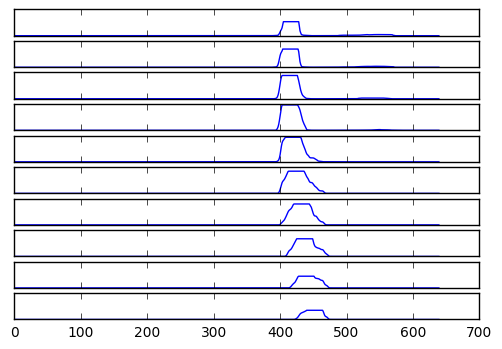

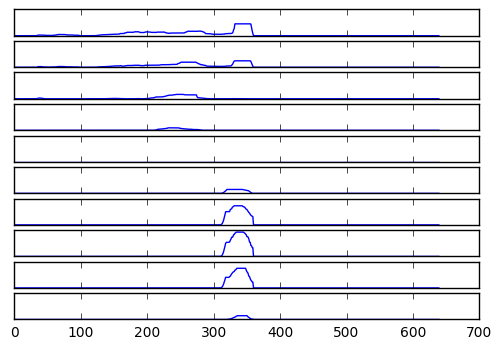

[[ 720.          413.67681011]
 [ 648.          413.03603154]
 [ 576.          413.40940814]
 [ 504.          414.79693991]
 [ 432.          417.19862685]
 [ 360.          420.61446896]
 [ 288.          425.04446624]
 [ 216.          430.4886187 ]
 [ 144.          436.94692632]
 [  72.          444.41938912]
 [   0.          452.90600709]]
[[  720.          1008.86815718]
 [  648.           980.74718274]
 [  576.           960.09697026]
 [  504.           946.91751975]
 [  432.           941.2088312 ]
 [  360.           942.97090462]
 [  288.           952.20374   ]
 [  216.           968.90733735]
 [  144.           993.08169665]
 [   72.          1024.72681793]
 [    0.          1063.84270116]]


IndexError: index 720 is out of bounds for axis 0 with size 720

In [87]:
def calculate_lane_area(lanes, img_height, steps):
    points_left = np.zeros((steps + 1, 2))
    points_right = np.zeros((steps + 1, 2))

    for i in range(steps + 1):
        pixels_per_step = img_height//steps
        start = img_height - i * pixels_per_step

        points_left[i] = [start, lanes[0].best_fit_poly(start)]
        points_right[i] = [start, lanes[1].best_fit_poly(start)]
    print(points_left)
    print(points_right)

    return np.concatenate((points_left, points_right[::-1]), axis=0)

img = imread('test_images/test1.jpg')
left_lane = Line(FRAME_MEMORY)
right_lane = Line(FRAME_MEMORY)

img = image_pipline(img, lanes=(left_lane, right_lane))
plt.imshow(img)

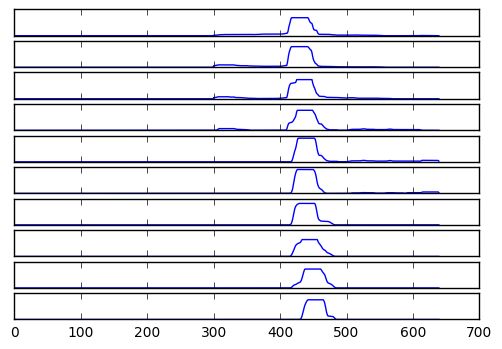

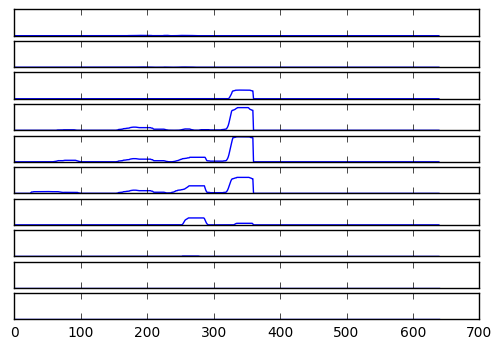

[[ 720.          425.14736011]
 [ 648.          427.43044757]
 [ 576.          429.8186947 ]
 [ 504.          432.31210149]
 [ 432.          434.91066795]
 [ 360.          437.61439407]
 [ 288.          440.42327985]
 [ 216.          443.3373253 ]
 [ 144.          446.35653041]
 [  72.          449.48089518]
 [   0.          452.71041962]]
[[ 720.          614.47932341]
 [ 648.          758.49955443]
 [ 576.          868.08800334]
 [ 504.          943.24467013]
 [ 432.          983.96955481]
 [ 360.          990.26265738]
 [ 288.          962.12397783]
 [ 216.          899.55351618]
 [ 144.          802.5512724 ]
 [  72.          671.11724652]
 [   0.          505.25143852]]
Left line:
[  1.01427145e-05  -4.55847815e-02   4.52710420e+02]
Right line:
[ -3.32096664e-03   2.54280138e+00   5.05251439e+02]
are parallel:
False
distance between lines is 52.5410189


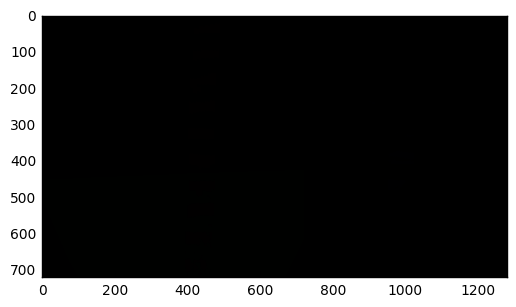

In [81]:
img = imread('test_images/test4.jpg')

left_lane = Line(FRAME_MEMORY)
right_lane = Line(FRAME_MEMORY)

img = image_pipline(img, lanes=(left_lane, right_lane))

plt.imshow(img, cmap='gray')
print('Left line:')
print(left_lane.current_fit)
print('Right line:')
print(right_lane.current_fit)
print('are parallel:')
print(left_lane.is_current_fit_parallel(right_lane, (1,1)))
print('distance between lines is %s' % left_lane.get_current_fit_distance(right_lane))

In [175]:
images = []
for i in range(1, 9):
    images.append(imread('test_images/test%s.jpg' % i))

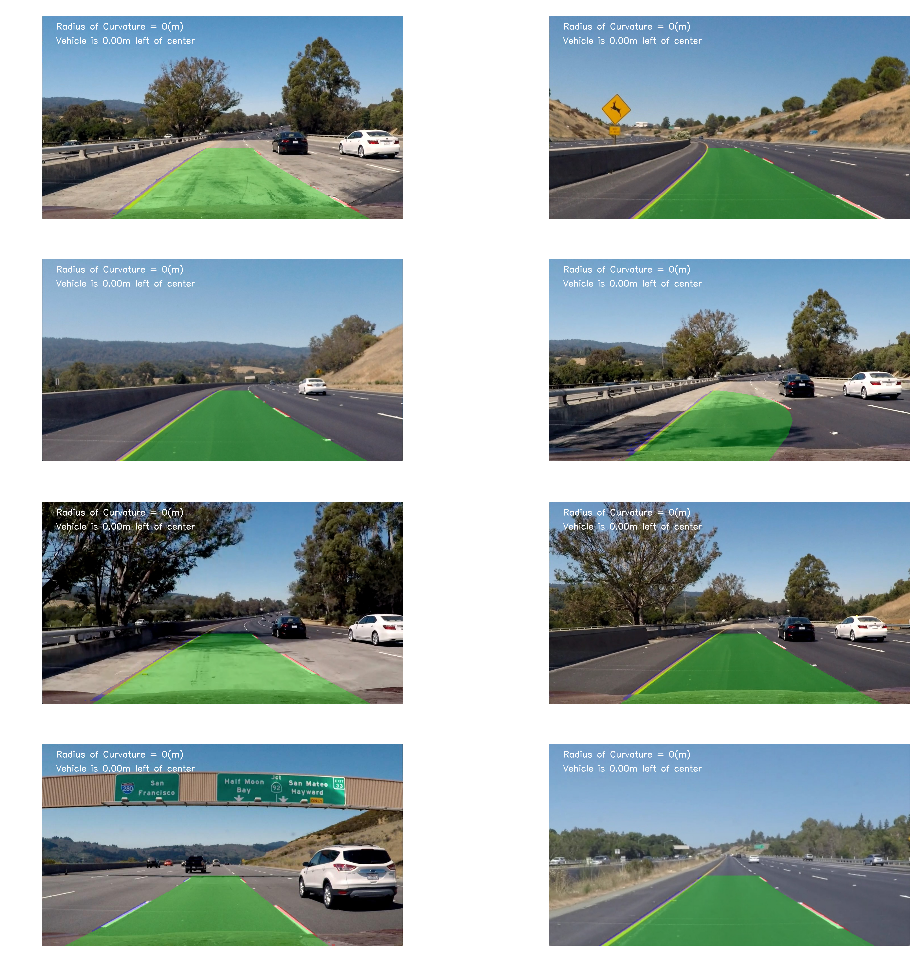

In [9]:
rows=4
cols=2
fig, axis = plt.subplots(rows, cols, figsize=(12, 3*rows))
for row in range(rows):
    for col in range(cols):
        index = row * cols + col
        img = images[index]
        left_line = Line(FRAME_MEMORY)
        right_line = Line(FRAME_MEMORY)
        img = image_pipline(img, lanes=(left_lane, right_lane))

        axis[row, col].imshow(img, cmap='gray')
        axis[row, col].axis('off')

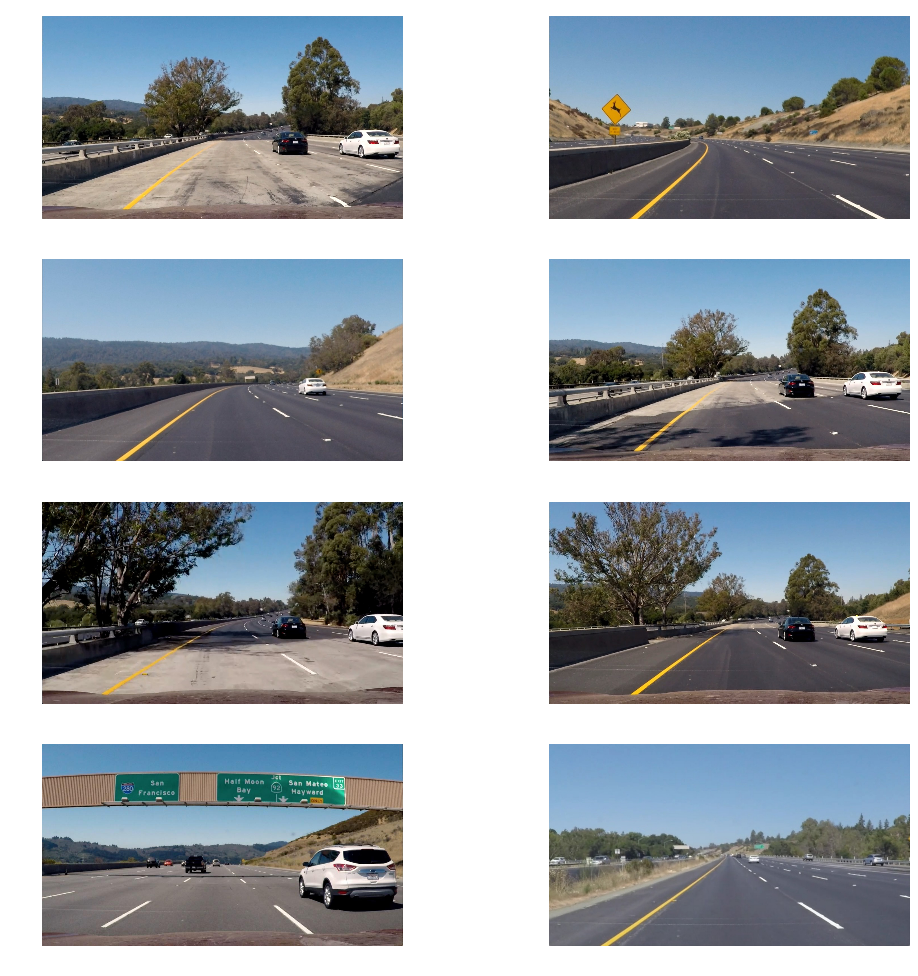

In [10]:
fig, axis = plt.subplots(rows, cols, figsize=(12, 3*rows))
for row in range(rows):
    for col in range(cols):
        index = row * cols + col
        img = images[index]

        axis[row, col].imshow(img, cmap='gray')
        axis[row, col].axis('off')

# Video Processing

In [12]:
left_line = Line(FRAME_MEMORY)
right_line = Line(FRAME_MEMORY)

project_output = 'short_ann.mp4'
clip1 = VideoFileClip("short.mp4")
project_clip = clip1.fl_image(lambda img: image_pipline(img, (left_line, right_line)))
%time project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video short_ann.mp4
[MoviePy] Writing video short_ann.mp4


 99%|█████████▉| 134/135 [02:58<00:01,  1.69s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: short_ann.mp4 

CPU times: user 4min 38s, sys: 6.66 s, total: 4min 45s
Wall time: 2min 59s


In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))